# Assignment 3 - Part 1

## Saving and loading models, with application to the EuroSat dataset

### Instructions

In this assignment, you will create a neural network that classifies land uses and land covers from satellite imagery. You will save your model using Tensorflow's callbacks and reload it later. You will also load in a pre-trained neural network classifier and compare performance with it. 

Some code cells are provided you in the notebook. You should avoid editing provided code, and make sure to execute the cells in order to avoid unexpected errors. Some cells begin with the line: 

`# YOUR CODE HERE`

Don't move or edit this first line - this is what the automatic grader looks for to recognise graded cells. These cells require you to write your own code to complete them, and are automatically graded when you submit the notebook. Don't edit the function name or signature provided in these cells, otherwise the automatic grader might not function properly. Inside these graded cells, you can use any functions or classes that are imported below, but make sure you don't use any variables that are outside the scope of the function. In addition, do not use any packages that are not already loaded in this notebook

### Let's get started!

We'll start running some imports, and loading the dataset. Do not edit the existing imports in the following cell.

## Credits
Some of the material in this notebook has been taken from a Coursera Deep Learning course 

In [3]:
#### PACKAGE IMPORTS ####

# Run this cell first to import all required packages. Do not make any imports elsewhere in the notebook

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
%matplotlib inline

import os
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns
import math

#### The EuroSAT dataset

In this assignment, you will use the [EuroSAT dataset](https://github.com/phelber/EuroSAT). It consists of 27000 labelled Sentinel-2 satellite images of different land uses: residential, industrial, highway, river, forest, pasture, herbaceous vegetation, annual crop, permanent crop and sea/lake. 

![Overview of Eurosat dataset](eurosat_overview_small.jpeg)

For a reference, see the following papers:
- Eurosat: A novel dataset and deep learning benchmark for land use and land cover classification. Patrick Helber, Benjamin Bischke, Andreas Dengel, Damian Borth. IEEE Journal of Selected Topics in Applied Earth Observations and Remote Sensing, 2019.
- Introducing EuroSAT: A Novel Dataset and Deep Learning Benchmark for Land Use and Land Cover Classification. Patrick Helber, Benjamin Bischke, Andreas Dengel. 2018 IEEE International Geoscience and Remote Sensing Symposium, 2018.

Your goal is to construct a neural network that classifies a satellite image into one of these 10 classes, as well as applying some of the saving and loading techniques you have learned in lab 09. In addition, you will apply transfer learning to perform classification on this dataset.

#### Import the data

The dataset you will train your model on is a subset of the total data, with 4000 training images and 1000 testing images, with roughly equal numbers of each class. 
The train and test datasets required for this project can
be downloaded from Canvas. The `data` folder is in the same directory as the `release` folder. 

The datasets will be loaded below into variables `x_train`, `y_train`, `x_test`, `y_test`.

In [4]:
# Import the Eurosat data from local folder. Assuming it is placed in a data folder relative to this notebook.

def load_eurosat_data():
    x_train = np.load('../../data/x_train.npy')
    y_train = np.load('../../data/y_train.npy')
    x_test  = np.load('../../data/x_test.npy')
    y_test  = np.load('../../data/y_test.npy')
    return (x_train, y_train), (x_test, y_test)

In [5]:
(x_train, y_train), (x_test, y_test) = load_eurosat_data()

#Pre-process images
x_train = x_train / 255.0
x_test = x_test / 255.0

In [6]:
print("{} training data examples".format(x_train.shape[0]))
print("{} test data examples".format(x_test.shape[0]))

print("Shape of first training image: {}".format(x_train[0].shape))
print("Training label of first training image: {}".format(y_train[0]))
print(y_train.min(), y_train.max())

4000 training data examples
1000 test data examples
Shape of first training image: (64, 64, 3)
Training label of first training image: [2]
0 9


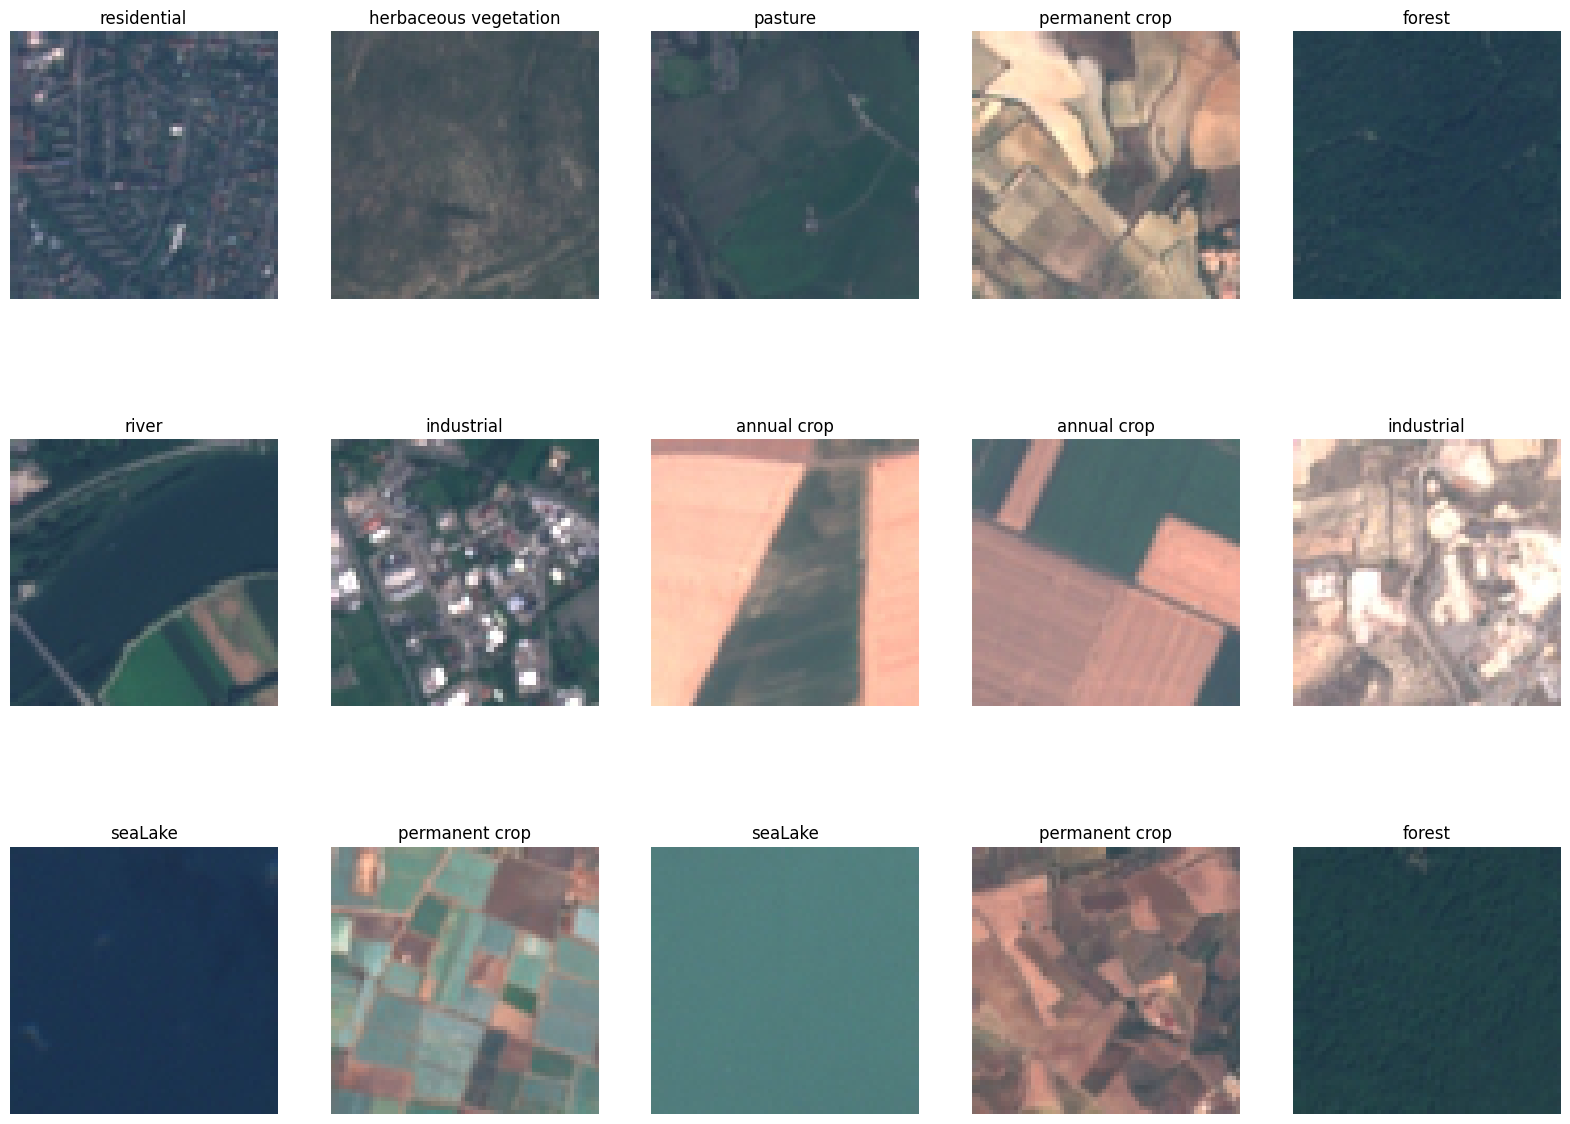

In [7]:
# Display a few images and labels
#Run this cell multiple times to get flavor of the kind of images in this dataset

class_names = ['annual crop', 'forest', 'herbaceous vegetation', 'highway',  'industrial',   'pasture', 
                         'permanent crop', 'residential', 'river', 'seaLake']

plt.figure(figsize=(20,15))
inx = np.random.choice(x_train.shape[0], 15, replace=False)
for n, i in enumerate(inx):
    ax = plt.subplot(3,5,n+1)
    plt.imshow(x_train[i])
    plt.title(class_names[y_train[i][0]])
    plt.axis('off')

In [8]:
for i in range(10):
    print(f"Number of images with class label {class_names[i]} = {np.sum(y_train == i)}")

Number of images with class label annual crop = 406
Number of images with class label forest = 400
Number of images with class label herbaceous vegetation = 394
Number of images with class label highway = 410
Number of images with class label industrial = 397
Number of images with class label pasture = 419
Number of images with class label permanent crop = 411
Number of images with class label residential = 398
Number of images with class label river = 397
Number of images with class label seaLake = 368


In [9]:
# same as above but in one line
# class distribution for yTrain 
np.array(np.unique(y_train, return_counts=True)).T

array([[  0, 406],
       [  1, 400],
       [  2, 394],
       [  3, 410],
       [  4, 397],
       [  5, 419],
       [  6, 411],
       [  7, 398],
       [  8, 397],
       [  9, 368]])

#### Build the neural network model

You can now construct a model to fit to the data. Using the Sequential API, build your model according to the following specifications:

* The model should use the input_shape in the function argument to set the input size in the first layer.
* The first layer should be a Conv2D layer with 16 filters, a 3x3 kernel size, a ReLU activation function and 'SAME' padding. Name this layer 'conv_1'.
* The second layer should also be a Conv2D layer with 8 filters, a 3x3 kernel size, a ReLU activation function and 'SAME' padding. Name this layer 'conv_2'.
* The third layer should be a MaxPooling2D layer with a pooling window size of 8x8. Name this layer 'pool_1'.
* The fourth layer should be a Flatten layer, named 'flatten'.
* The fifth layer should be a Dense layer with 32 units, a ReLU activation. Name this layer 'dense_1'.
* The sixth and final layer should be a Dense layer with 10 units and softmax activation. Name this layer 'dense_2'.

In total, the network should have 6 layers.

In [10]:
#### GRADED CELL ####

# Complete the following function. 
# Make sure to not change the function name or arguments.

def get_new_model(input_shape):
    """
    This function should build a Sequential model according to the above specification. Ensure the 
    weights are initialised by providing the input_shape argument in the first layer, given by the
    function argument.
    Your function should also compile the model with the Adam optimiser, a cross
    entropy loss function (which one? categorical or sparse categorical?), and a single accuracy metric.
    """
    
    # YOUR CODE HERE
    model = Sequential([
        Conv2D(filters=16, input_shape=input_shape, kernel_size=(3, 3), 
               activation='relu', padding='same', name='conv_1'),
        Conv2D(filters=8, kernel_size=(3, 3), activation='relu', padding='same', name='conv_2'),
        MaxPooling2D(pool_size=(8, 8), name='pool_1'),
        Flatten(name='flatten'),
        Dense(units=32, activation='relu', name='dense_1'),
        Dense(units=10, activation='softmax', name='dense_2')
    ])
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model
    

#### Compile and evaluate the model

In [11]:
# Run your function to create the model
print(x_train[0].shape)
model = get_new_model(x_train[0].shape)

(64, 64, 3)
Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2022-11-09 09:13:42.747954: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-11-09 09:13:42.748303: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [12]:
#Print the model summary 
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_1 (Conv2D)             (None, 64, 64, 16)        448       
                                                                 
 conv_2 (Conv2D)             (None, 64, 64, 8)         1160      
                                                                 
 pool_1 (MaxPooling2D)       (None, 8, 8, 8)           0         
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 32)                16416     
                                                                 
 dense_2 (Dense)             (None, 10)                330       
                                                                 
Total params: 18,354
Trainable params: 18,354
Non-traina

In [13]:
assert len(model.layers) == 6, "There should be total of 6 layers"
assert isinstance(model.layers[0], tf.keras.layers.Conv2D), "First layer should be a Conv2D layer"
assert (model.layers[4]).output_shape[1] == 32, "Fifth layer has output shape (None, 32)"

#get layer with name 'conv_2'
layer = model.get_layer('conv_2')
assert isinstance(layer, tf.keras.layers.Conv2D), "Layer with name conv_2 is a Conv2D layer"
assert isinstance(model.optimizer, tf.keras.optimizers.Adam), "Optimizer should be of type Adam"


In [14]:
# Run this cell to define a function to evaluate a model's test accuracy

def get_test_accuracy(model, x_test, y_test):
    """Test model classification accuracy"""
    test_loss, test_acc = model.evaluate(x=x_test, y=y_test, verbose=0)
    print('accuracy: {acc:0.3f}'.format(acc=test_acc))
    return test_acc

In [15]:
# Calculate its initial test accuracy (without any training)

test_init = get_test_accuracy(model, x_test, y_test)

2022-11-09 09:13:43.307267: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-11-09 09:13:43.412801: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


accuracy: 0.040


#### Create checkpoints to save model during training, with a criterion

You will now create three callbacks:
- `checkpoint_every_epoch`: checkpoint that saves the model weights every epoch during training
- `checkpoint_best_only`: checkpoint that saves only the weights with the highest validation accuracy. **Use the testing data as the validation data.**
- `early_stopping`: early stopping object that ends training if the validation accuracy has not improved in 3 epochs.

In [16]:
#### GRADED CELL ####

# Complete the following functions. 
# Make sure to not change the function names or arguments.

def get_checkpoint_every_epoch():
    """
    This function should return a ModelCheckpoint object that:
    - saves the weights only at the end of every epoch
    - saves into a directory called 'checkpoints_every_epoch' inside the current working directory
    - generates filenames in that directory like 'checkpoint_XXX' where
      XXX is the epoch number formatted to have three digits, e.g. 001, 002, 003, etc.
    """
    # YOUR CODE HERE
    checkpoint_path = 'checkpoints_every_epoch/checkpoint_{epoch:03d}'
    checkpoint = ModelCheckpoint(filepath=checkpoint_path, #where you want to store it
                             frequency = 'epoch', #how often
                             save_weights_only=True, #what to save
                             verbose=1)
    return checkpoint

In [17]:
#### GRADED CELL ####

# Complete the following functions. 
# Make sure to not change the function names or arguments.

def get_checkpoint_best_only():
    """
    This function should return a ModelCheckpoint object that:
    - saves only the weights that generate the highest validation (testing) accuracy
    - saves into a directory called 'checkpoints_best_only' inside the current working directory
    - generates a file called 'checkpoints_best_only/checkpoint' 
    """
    # YOUR CODE HERE
    checkpoint_path = 'checkpoints_best_only/checkpoint'
    checkpoint = ModelCheckpoint(filepath=checkpoint_path, #where you want to store it
                             frequency = 'epoch',
                             save_weights_only=True,
                             save_best_only=True,
                             monitor='val_accuracy', #what to save
                             verbose=1)
    return checkpoint
    

In [18]:
#### GRADED CELL ####

# Complete the following function. 
# Make sure to not change the function name or arguments.

def get_early_stopping():
    """
    This function should return an EarlyStopping callback that stops training when
    the validation (testing) accuracy has not improved in the last 3 epochs. 
    Set verbose = 1.
    HINT: use the EarlyStopping callback with the correct 'monitor' and 'patience'
    """
    # YOUR CODE HERE
    early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, min_delta = 0.01, verbose=1)
    return early_stopping
    

In [19]:
# Run this cell to create the callbacks

checkpoint_every_epoch = get_checkpoint_every_epoch()
checkpoint_best_only = get_checkpoint_best_only()
early_stopping = get_early_stopping()

In [20]:
assert (checkpoint_every_epoch.save_best_only == False)
assert (checkpoint_every_epoch.save_weights_only)
assert (checkpoint_every_epoch.save_freq == 'epoch')

assert (checkpoint_best_only.save_best_only)
assert (checkpoint_best_only.save_weights_only)
assert (checkpoint_best_only.save_freq  == 'epoch')
assert (checkpoint_best_only.monitor == 'val_accuracy')

assert (early_stopping.monitor == 'val_accuracy')
assert (early_stopping.patience == 3)

#### Train model using the callbacks

Now, you will train the model using the three callbacks you created. If you created the callbacks correctly, three things should happen:
- At the end of every epoch, the model weights are saved into a directory called `checkpoints_every_epoch`
- At the end of every epoch, the model weights are saved into a directory called `checkpoints_best_only` **only** if those weights lead to the highest test accuracy
- Training stops when the testing accuracy has not improved in three epochs.

You should then have two directories:
- A directory called `checkpoints_every_epoch` containing filenames that include `checkpoint_001`, `checkpoint_002`, etc with the `001`, `002` corresponding to the epoch
- A directory called `checkpoints_best_only` containing filenames that include `checkpoint`, which contain only the weights leading to the highest testing accuracy

In [21]:
# Train model using the callbacks you just created

callbacks = [checkpoint_every_epoch, checkpoint_best_only, early_stopping]
history = model.fit(x_train, y_train, epochs=50, validation_data=(x_test, y_test), callbacks=callbacks)

Epoch 1/50


2022-11-09 09:13:44.611511: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


124/125 [============================>.] - ETA: 0s - loss: 2.1239 - accuracy: 0.1626
Epoch 1: saving model to checkpoints_every_epoch/checkpoint_001

Epoch 1: val_accuracy improved from -inf to 0.30600, saving model to checkpoints_best_only/checkpoint
125/125 [==============================] - 3s 22ms/step - loss: 2.1222 - accuracy: 0.1635 - val_loss: 1.8268 - val_accuracy: 0.3060
Epoch 2/50
124/125 [============================>.] - ETA: 0s - loss: 1.5491 - accuracy: 0.3936
Epoch 2: saving model to checkpoints_every_epoch/checkpoint_002

Epoch 2: val_accuracy improved from 0.30600 to 0.44800, saving model to checkpoints_best_only/checkpoint
125/125 [==============================] - 3s 21ms/step - loss: 1.5468 - accuracy: 0.3953 - val_loss: 1.4018 - val_accuracy: 0.4480
Epoch 3/50
124/125 [============================>.] - ETA: 0s - loss: 1.3482 - accuracy: 0.4725
Epoch 3: saving model to checkpoints_every_epoch/checkpoint_003

Epoch 3: val_accuracy improved from 0.44800 to 0.48200, s

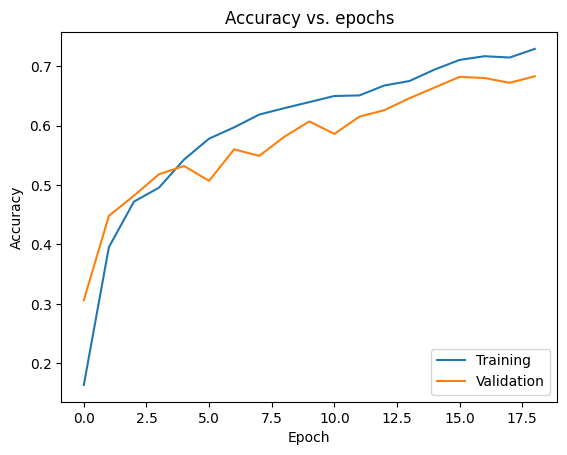

In [22]:
#Run this cell to plot the accuracy vs epoch graph

try:
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
except KeyError:
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show() 

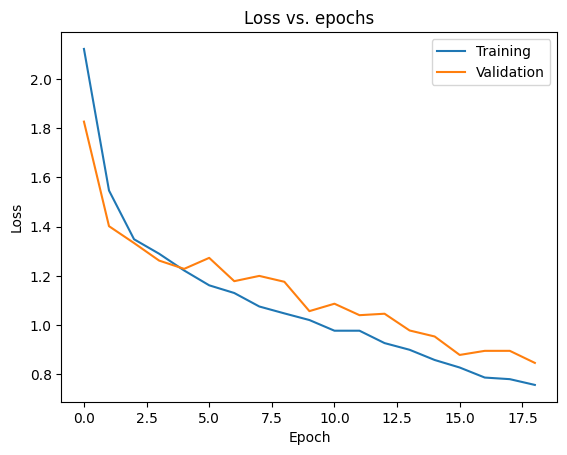

In [23]:
#Run this cell to plot the new loss vs epoch graph

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show() 

In [24]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [25]:
#Evaluate the model on the test set (which is the same as the validation set for now)
test_acc = get_test_accuracy(model, x_test, y_test)
train_acc = get_test_accuracy(model, x_train, y_train)

accuracy: 0.683
accuracy: 0.752


In [26]:
assert test_acc > 0.60, f"Model accuracy on test set should be greater than 60% but received {test_acc*100}"

#### Create new instance of model and load on both sets of weights

Now you will use the weights you just saved in a fresh model. You should create two functions, both of which take a freshly instantiated model instance as a parameter:
- `model_last_epoch` should contain the weights from the latest saved epoch
- `model_best_epoch` should contain the weights from the saved epoch with the highest testing accuracy

_Hint: use the_ `tf.train.latest_checkpoint` _function to get the filename of the latest saved checkpoint file. Check the docs_ [_here_](https://www.tensorflow.org/api_docs/python/tf/train/latest_checkpoint).

In [27]:
#### GRADED CELL ####

# Complete the following function. 
# Make sure to not change the function name or arguments.

def get_model_last_epoch(model):
    """
    This function should create a new instance of the CNN you created earlier,
    load on the weights from the last training epoch, and return this model.
    """
    # YOUR CODE HERE
    checkpoint_dir = 'checkpoints_every_epoch'
    checkpoint_path = tf.train.latest_checkpoint(
        checkpoint_dir
    )

    model.load_weights(checkpoint_path)
    return model
    

In [28]:
#### GRADED CELL ####

# Complete the following functions. 
# Make sure to not change the function name or arguments.

def get_model_best_epoch(model):
    """
    This function should create a new instance of the CNN you created earlier, load 
    on the weights leading to the highest validation accuracy, and return this model.
    """
    # YOUR CODE HERE
    checkpoint_dir= "checkpoints_best_only"
    checkpoint_path = tf.train.latest_checkpoint(
        checkpoint_dir
    )

    model.load_weights(checkpoint_path)
    return model


In [29]:
# Run this cell to create two models: one with the weights from the last training
# epoch, and one with the weights leading to the highest validation (testing) accuracy.
# Verify that the second has a higher validation (testing) accuarcy.

model_last_epoch = get_model_last_epoch(get_new_model(x_train[0].shape))
model_best_epoch = get_model_best_epoch(get_new_model(x_train[0].shape))

In [30]:
print('Model with last epoch weights:')
test_acc_last_epoch = get_test_accuracy(model_last_epoch, x_test, y_test)
print('')
print('Model with best epoch weights:')
test_acc_best_epoch = get_test_accuracy(model_best_epoch, x_test, y_test)
assert test_acc_best_epoch >= test_acc_last_epoch, f"Best Epoch accuracy {test_acc_best_epoch} should be >= Last Epoch accuracy {test_acc_last_epoch}"

Model with last epoch weights:


2022-11-09 09:14:37.485843: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


accuracy: 0.683

Model with best epoch weights:


2022-11-09 09:14:37.857755: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


accuracy: 0.683


In [31]:
# Define functions for evaluating model accuracy by class and overall

def eval_model_by_class(model, x_test, y_test):
    
    label_count = np.unique(y_test, return_counts = True)[1]
    #Predict test images
    predict_x = model.predict(x_test)
    #Get corresponding predicted label
    y_pred=np.argmax(predict_x,axis=1)       
      
    y_test = [class_names[x] for x in y_test.reshape(-1)]
    y_pred = [class_names[x] for x in y_pred]

    pred_df = pd.DataFrame({'y_true': y_test, 'y_pred': y_pred})
    pred_df['accurate_preds'] = pred_df.y_true == pred_df.y_pred
    pred_df = pred_df.groupby(['y_true']).sum().reset_index()
    pred_df['label_count'] = label_count
    pred_df['class_acc'] = pred_df.accurate_preds / pred_df.label_count
    pred_df = pred_df.sort_values(by = 'class_acc').reset_index()
    pred_df['overall_acc'] = sum(pred_df.accurate_preds) / sum(pred_df.label_count)
    pred_df = pred_df.sort_values('y_true').reset_index(drop = True)

    return(pred_df)

In [32]:
eval_model_by_class(model_best_epoch, x_test, y_test)

32/32 [==============================] - 0s 4ms/step


2022-11-09 09:14:38.229182: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
/var/folders/2f/x34mbmns63s51s11j986b8qw0000gn/T/ipykernel_24772/3922503301.py:16: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  pred_df = pred_df.groupby(['y_true']).sum().reset_index()


,index,y_true,accurate_preds,label_count,class_acc,overall_acc
0,0,annual crop,70,90,0.777778,0.683
1,1,forest,82,96,0.854167,0.683
2,2,herbaceous vegetation,46,104,0.442308,0.683
3,3,highway,16,92,0.173913,0.683
4,4,industrial,85,91,0.934066,0.683
5,5,pasture,76,104,0.730769,0.683
6,6,permanent crop,74,110,0.672727,0.683
7,7,residential,98,106,0.924528,0.683
8,8,river,46,110,0.418182,0.683
9,9,seaLake,90,97,0.927835,0.683


In [33]:
# Function to Plot confusion matrix

def confMat(model, x_test, y_test):
    plt.figure(figsize=(15, 5))

    #Predict test images
    predict_x = model.predict(x_test)
    #Get corresponding predicted label
    y_pred=np.argmax(predict_x,axis=1)

    cm = confusion_matrix(y_test, y_pred)
    df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)

    plt.title("Confusion matrix\n")
    sns.heatmap(df_cm, annot=True, fmt="d", cmap="YlGnBu")
    plt.ylabel("Predicted")
    plt.xlabel("Actual")
    plt.show()

32/32 [==============================] - 0s 4ms/step


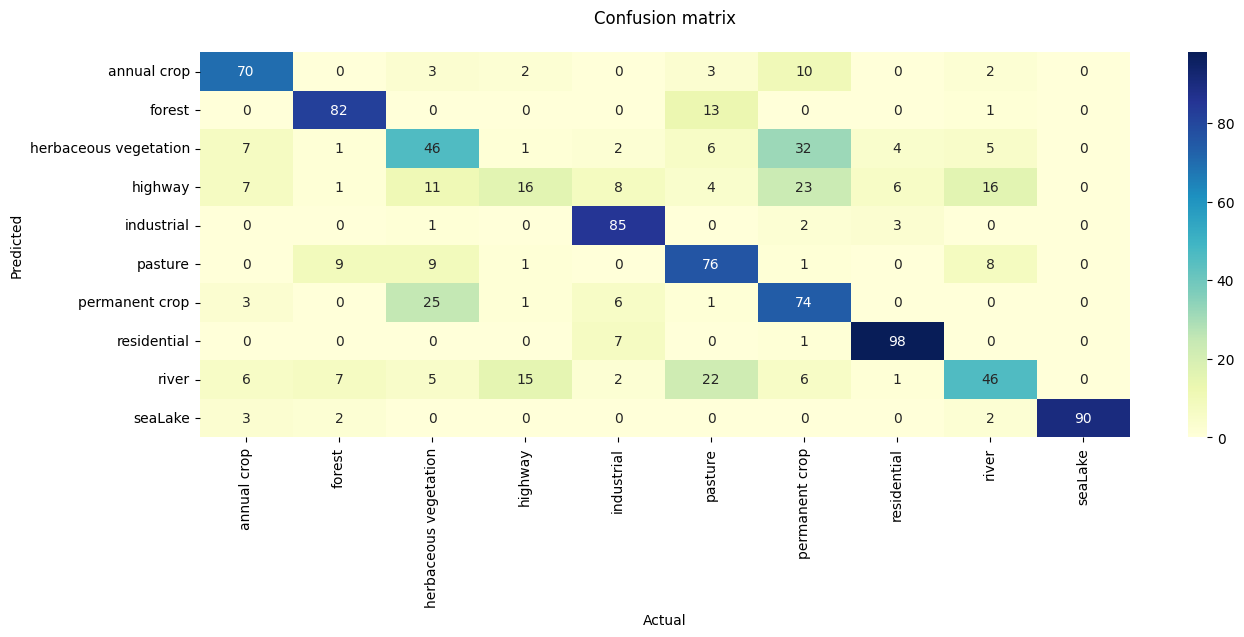

In [34]:
# Plot confusion matrices for model_best_epoch
confMat(model_best_epoch, x_test, y_test)

### Time to amp up the performance

In [35]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import Input, layers
from tensorflow.keras.applications.resnet50 import preprocess_input


In [65]:
#### GRADED CELL ####

# Complete the following function. 
# Make sure to not change the function name or arguments.


def get_TL_model(input_shape):
    """
    This function will create a model derived from Resnet50. 
        It will include all but the last layer of Resnet50 (essentially the output should have a shape of (None, 2048).
        It will then add a Dense layer with 64 units and RELU activation, a dropout layer with probability 0.5, 
    followed by output Dense layer with 10 units and Softmax activation.
    
    Only the new layers added are trainable (all the layers of Resnet50 should be frozen).
    
    Ensure the input shape of the Resnet50 is set using the input_shape argument, given by the
    function argument.
    
    Your function should also compile the model with the Adam optimiser, a sparse categorical cross
    entropy loss function, and a single accuracy metric.
    """
    
    # YOUR CODE HERE
    model_resnet = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape, pooling='avg')

    new_model = Sequential([
        model_resnet,
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.75),
        layers.Dense(10, activation='softmax')
        #layers.BatchNormalization()
    ])

    new_model.layers[0].trainable = False

    opt = tf.keras.optimizers.Adam(learning_rate=0.0001)

    new_model.compile(
        optimizer= opt,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return new_model

In [50]:
model_TL = get_TL_model(x_train[0].shape)
model_TL.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense_6 (Dense)             (None, 64)                131136    
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_7 (Dense)             (None, 10)                650       
                                                                 
Total params: 23,719,498
Trainable params: 131,786
Non-trainable params: 23,587,712
_________________________________________________________________


/opt/miniconda3/envs/tflabs/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [38]:
numTrainableParams = np.sum([np.prod(v.get_shape()) for v in model_TL.trainable_weights])
numNonTrainableParams = np.sum([np.prod(v.get_shape()) for v in model_TL.non_trainable_weights])

assert (numTrainableParams == 131786), f"Trainable parameters should be 131786 but got {numTrainableParams}"
assert (numNonTrainableParams == 23587712), f"Non-Trainable parameters should be 23587712 but got {numNonTrainableParams}"
assert isinstance(model_TL.layers[-2], tf.keras.layers.Dropout), "Penultimate layer should be a Dropout layer"
print("All tests passed!")


All tests passed!


In [39]:
#### GRADED CELL ####

# Complete the following function. 
# Make sure to not change the function name or arguments.

def get_preprocessed_input():
    '''
    Pre-processes the Eurosat data using Resnet50 preprocessing function.
    
    Returns the tupple of pre-processed training and test data.
    '''
    # YOUR CODE HERE
    (x_train, y_train), (x_test, y_test) = load_eurosat_data() #x_train is image, y_train is a label
    train_images = preprocess_input(x_train)
    test_images = preprocess_input(x_test)
    return train_images, test_images

In [40]:
x_train_resnet, x_test_resnet = get_preprocessed_input()

In [41]:
#Get minimum value of each training image
x_train_min = x_train_resnet.min(axis = (1, 2, 3))

#Get maximum value of each test image
x_test_max = x_test_resnet.max(axis = (1, 2, 3))

assert math.isclose(x_train_min.mean(), -80.72776225)
assert math.isclose(x_test_max.mean(), 78.431189)
print("All tests passed!")

All tests passed!


In [66]:
checkpoint_best_only = get_checkpoint_best_only()
early_stopping = get_early_stopping()
callbacks = [checkpoint_best_only, early_stopping]

In [67]:

new_history = model_TL.fit(x_train_resnet, y_train, epochs=50, validation_data=(x_test_resnet, y_test), callbacks=callbacks)


Epoch 1/50
125/125 [==============================] - ETA: 0s - loss: 0.1621 - accuracy: 0.9518
Epoch 1: val_accuracy improved from -inf to 0.91800, saving model to checkpoints_best_only/checkpoint
125/125 [==============================] - 8s 60ms/step - loss: 0.1621 - accuracy: 0.9518 - val_loss: 0.2685 - val_accuracy: 0.9180
Epoch 2/50
124/125 [============================>.] - ETA: 0s - loss: 0.1573 - accuracy: 0.9536
Epoch 2: val_accuracy did not improve from 0.91800
125/125 [==============================] - 7s 57ms/step - loss: 0.1581 - accuracy: 0.9535 - val_loss: 0.2604 - val_accuracy: 0.9170
Epoch 3/50
125/125 [==============================] - ETA: 0s - loss: 0.1397 - accuracy: 0.9623
Epoch 3: val_accuracy improved from 0.91800 to 0.92200, saving model to checkpoints_best_only/checkpoint
125/125 [==============================] - 7s 59ms/step - loss: 0.1397 - accuracy: 0.9623 - val_loss: 0.2563 - val_accuracy: 0.9220
Epoch 4/50
125/125 [==============================] - ETA:

In [62]:
#Reload the model with the best epoch
model_TL_best_epoch = get_model_best_epoch(get_TL_model(x_train[0].shape))

print('TL Model with best epoch weights:')
test_acc_TL_best_epoch = get_test_accuracy(model_TL_best_epoch, x_test_resnet, y_test)
train_acc_TL_best_epoch = get_test_accuracy(model_TL_best_epoch, x_train_resnet, y_train)

TL Model with best epoch weights:


2022-11-09 09:45:37.588435: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


accuracy: 0.921
accuracy: 0.974


In [45]:
assert test_acc_TL_best_epoch > 0.90, f"After Transfer Learning, test accuracy should be atleast 90% but got {test_acc_TL_best_epoch*100}"

In [46]:
eval_model_by_class(model_TL_best_epoch, x_test_resnet, y_test)

2022-11-09 09:15:52.699162: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 2s 44ms/step


/var/folders/2f/x34mbmns63s51s11j986b8qw0000gn/T/ipykernel_24772/3922503301.py:16: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  pred_df = pred_df.groupby(['y_true']).sum().reset_index()


,index,y_true,accurate_preds,label_count,class_acc,overall_acc
0,0,annual crop,80,90,0.888889,0.926
1,1,forest,90,96,0.937500,0.926
2,2,herbaceous vegetation,94,104,0.903846,0.926
3,3,highway,78,92,0.847826,0.926
4,4,industrial,90,91,0.989011,0.926
5,5,pasture,102,104,0.980769,0.926
6,6,permanent crop,104,110,0.945455,0.926
7,7,residential,101,106,0.952830,0.926
8,8,river,97,110,0.881818,0.926
9,9,seaLake,90,97,0.927835,0.926


32/32 [==============================] - 1s 38ms/step


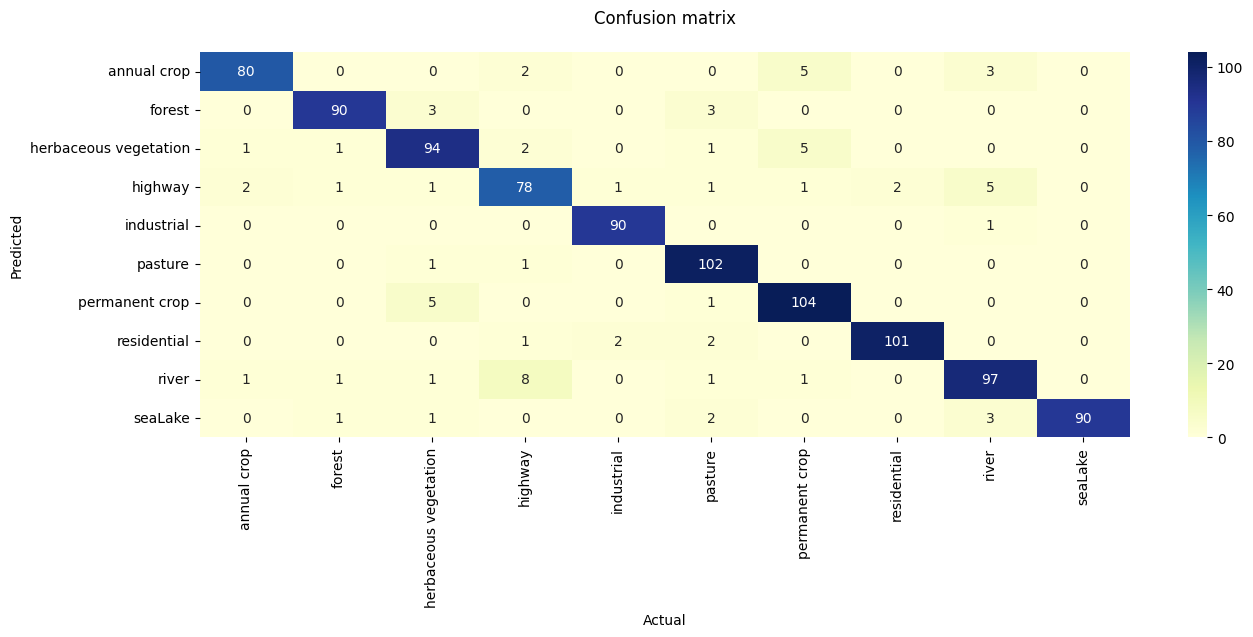

In [47]:
confMat(model_TL_best_epoch, x_test_resnet, y_test)

### Improve the performance further. 

Some Ideas: 

1. Increase the number of units in the first Dense layer (currently set to 64) after the pre-trained network 
2. Do not freeze the entire pre-trained network but let the last few layers to be trainable. For this, you can use a for-loop that iterates through last k layers of the frozen model and sets the `trainable` attribute to `True`.
3. Use `ReduceLROnPlateau` callback to decay the learning rate as improvements in validation loss slowdown.
4. Use training data that has been augmented through random shearing, rotating, and flipping.

Code for this part is not autograded and, therefore, should NOT be included here. The code for this part and the results of these improvements would be included in a report for this assignment.